In [4]:
import polars as pl
import pandas as pd
import numpy as np
import openpyxl
import pandera as pa

In [296]:
dfs = []
start_year = 2020
end_year = 2023

for year in range(start_year, end_year+1):
	file_path = f"./datasets/internal_{year}.xlsx"
	workbook = openpyxl.load_workbook(file_path, read_only=True)
	num_sheets = len(workbook.sheetnames)

	for sheet_no in range(1, num_sheets + 1):
		for suffix in ['_2', '_1'] if year == start_year else ['_2']:

			cleaned_columns_list = [f'province{suffix}'
				, 'ratio_tourist_stay_2', 'ratio_tourist_stay_1', 'ratio_tourist_stay_change'
				, 'no_tourist_stay_2', 'no_tourist_stay_1', 'no_tourist_stay_change'
				, 'no_tourist_all_2', 'no_tourist_all_1', 'no_tourist_all_change'
				, 'no_tourist_thai_2', 'no_tourist_thai_1', 'no_tourist_thai_change'
				, 'no_tourist_foreign_2', 'no_tourist_foreign_1', 'no_tourist_foreign_change'
				, 'profit_all_2', 'profit_all_1', 'profit_all_change'
				, 'profit_tourist_thai_2', 'profit_tourist_thai_1', 'profit_tourist_thai_change'
				, 'profit_tourist_foreign_2', 'profit_tourist_foreign_1', 'profit_tourist_foreign_change']

			raw_excel = (pl.read_excel(file_path
			                           , sheet_id=sheet_no
			                           , xlsx2csv_options={"skip_empty_lines": True})
			             .to_pandas()
			             .dropna(axis=1, how='all'))

			raw_excel.columns = cleaned_columns_list
			raw_excel = (raw_excel
			             .drop(raw_excel[raw_excel.iloc[:,0] == "จังหวัด"].index)
			             .dropna(subset=[raw_excel.columns[0]])
			             .loc[lambda x: x[f'province{suffix}'].str.len() < 20]
			             .loc[lambda x: ~x[f'province{suffix}'].str.contains("ภาค")]
			             .loc[lambda x: ~x[f'province{suffix}'].str.contains("รวม")]
			             .filter(regex=suffix)
			             .replace("-", 0)
			             .fillna(0)
			             )

			raw_excel.columns = raw_excel.columns.str.replace(suffix, '')
			raw_excel = raw_excel.astype({col: 'float' for col in raw_excel.columns if col != 'province'})
			raw_excel = raw_excel.astype({col: 'int' for col in raw_excel.columns if col.startswith('no_')})
			raw_excel = raw_excel.apply(lambda x: x * 1_000_000 if x.name.startswith('profit_') else x)
			raw_excel = raw_excel.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)
			raw_excel['time'] = workbook.sheetnames[sheet_no - 1]
			raw_excel = (raw_excel
			             .assign(month=raw_excel['time'].str.extract('(\D+)'))
			             .drop(columns=['time']))

			if suffix == '_2':
				raw_excel['year'] = year
			else:
				raw_excel['year'] = year - 1

			dfs.append(raw_excel)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df['province'] = (combined_df['province']
                           .str.replace(r'(R1)', "", regex=True)
                           .str.replace(r'(\(|\))', "", regex=True)
                           .str.replace(r'R', "", regex=True)
                           .str.replace(r'*', "", regex=True)
                           .str.replace(r'ประจวบศีรีขันธ์', "ประจวบคีรีขันธ์", regex=True)
                           .str.replace(r'ศรีษะเกษ', "ศรีสะเกษ", regex=True)
                           .str.replace(r'จ.นคร', "นคร", regex=True)
                           .str.replace(r'^\s+', "", regex=True))

# calculate max_occupancy_no with occupancy_rate and no_tourist_stay
combined_df['max_occupancy_no'] = (combined_df['no_tourist_stay'] / combined_df['ratio_tourist_stay'])
combined_df['max_occupancy_no'] = combined_df['max_occupancy_no'].replace([np.inf, -np.inf], np.nan)
combined_df['max_occupancy_no'] = combined_df.groupby('province')['max_occupancy_no'].fillna(method='ffill')
combined_df['max_occupancy_no'] = combined_df.groupby('province')['max_occupancy_no'].fillna(method='bfill')
combined_df['max_occupancy_no'] = combined_df['max_occupancy_no']
combined_df

,province,ratio_tourist_stay,no_tourist_stay,no_tourist_all,no_tourist_thai,no_tourist_foreign,profit_all,profit_tourist_thai,profit_tourist_foreign,month,year,max_occupancy_no
0,กรุงเทพมหานคร,89.36,3213765,6046765,3573040,2473725,8.820289e+10,3.113765e+10,5.706524e+10,ม.ค.,2020,35964.245748
1,ลพบุรี,51.53,39765,242413,240280,2133,4.135700e+08,4.085800e+08,4.990000e+06,ม.ค.,2020,771.686396
2,พระนครศรีอยุธยา,66.07,107777,741902,556141,185761,1.462740e+09,1.059240e+09,4.035000e+08,ม.ค.,2020,1631.254730
3,สระบุรี,59.71,81682,195397,189741,5656,3.218600e+08,3.102800e+08,1.158000e+07,ม.ค.,2020,1367.978563
4,ชัยนาท,73.47,23128,72893,72380,513,9.193000e+07,9.109000e+07,8.400000e+05,ม.ค.,2020,314.795154
...,...,...,...,...,...,...,...,...,...,...,...,...
3845,ร้อยเอ็ด,52.97,32125,67845,67115,730,9.052000e+07,8.860000e+07,1.920000e+06,ก.พ.,2023,606.475363
3846,ศรีสะเกษ,39.82,21548,56593,56284,309,6.519000e+07,6.449000e+07,7.000000e+05,ก.พ.,2023,541.135108
3847,สุรินทร์,55.10,71567,98256,96184,2072,1.707500e+08,1.667500e+08,4.000000e+06,ก.พ.,2023,1298.856624
3848,อำนาจเจริญ,38.09,6589,21896,21496,400,2.370000e+07,2.298000e+07,7.200000e+05,ก.พ.,2023,172.985035


In [300]:
#get max occupancy no na rows
combined_df.describe().T


,count,mean,std,min,25%,50%,75%,max
ratio_tourist_stay,3850.0,3.892862e+01,2.273898e+01,0.0,2.017500e+01,4.181000e+01,5.619750e+01,9.586000e+01
no_tourist_stay,3850.0,1.051611e+05,2.516646e+05,0.0,1.627125e+04,4.457900e+04,9.090200e+04,3.335728e+06
no_tourist_all,3850.0,2.063285e+05,4.540485e+05,0.0,3.909175e+04,9.212150e+04,2.036460e+05,6.131044e+06
no_tourist_thai,3850.0,1.739624e+05,3.179206e+05,0.0,3.716925e+04,8.878200e+04,1.842558e+05,4.087756e+06
no_tourist_foreign,3850.0,3.236613e+04,1.702651e+05,0.0,4.925000e+01,5.530000e+02,5.189500e+03,2.473725e+06
profit_all,3850.0,1.343876e+09,6.572752e+09,0.0,6.332250e+07,1.954950e+08,5.060000e+08,1.102873e+11
profit_tourist_thai,3850.0,6.636436e+08,2.275008e+09,0.0,5.925000e+07,1.773100e+08,4.600250e+08,4.506024e+10
profit_tourist_foreign,3850.0,6.802322e+08,4.645318e+09,-4250.0,1.100000e+05,1.540000e+06,1.742000e+07,8.502520e+10
year,3850.0,2.020600e+03,1.200156e+00,2019.0,2.020000e+03,2.021000e+03,2.022000e+03,2.023000e+03
max_occupancy_no,3850.0,inf,NaN,0.0,7.097417e+02,1.276421e+03,2.156374e+03,inf


In [312]:
dfs = []
start_year = 2020
end_year = 2023

for year in range(start_year, end_year+1):
    file_path = f"./datasets/internal_{year}.xlsx"
    workbook = openpyxl.load_workbook(file_path, read_only=True)
    num_sheets = len(workbook.sheetnames)

    for sheet_no in range(1, num_sheets + 1):
        for suffix in ['_2', '_1'] if year == start_year else ['_2']:

            cleaned_columns_list = [f'province{suffix}'
                , 'ratio_tourist_stay_2', 'ratio_tourist_stay_1', 'ratio_tourist_stay_change'
                , 'no_tourist_stay_2', 'no_tourist_stay_1', 'no_tourist_stay_change'
                , 'no_tourist_all_2', 'no_tourist_all_1', 'no_tourist_all_change'
                , 'no_tourist_thai_2', 'no_tourist_thai_1', 'no_tourist_thai_change'
                , 'no_tourist_foreign_2', 'no_tourist_foreign_1', 'no_tourist_foreign_change'
                , 'net_profit_all_2', 'net_profit_all_1', 'net_profit_all_change'
                , 'net_profit_thai_2', 'net_profit_thai_1', 'net_profit_thai_change'
                , 'net_profit_foreign_2', 'net_profit_foreign_1', 'net_profit_foreign_change']

            raw_excel = (pl.read_excel(file_path
                                       , sheet_id=sheet_no
                                       , xlsx2csv_options={"skip_empty_lines": True})
                         .to_pandas()
                         .dropna(axis=1, how='all'))

            raw_excel.columns = cleaned_columns_list
            raw_excel = (raw_excel
                         .drop(raw_excel[raw_excel.iloc[:,0] == "จังหวัด"].index)
                         .dropna(subset=[raw_excel.columns[0]])
                         .loc[lambda x: x[f'province{suffix}'].str.len() < 20]
                         .loc[lambda x: ~x[f'province{suffix}'].str.contains("ภาค")]
                         .loc[lambda x: ~x[f'province{suffix}'].str.contains("รวม")]
                         .filter(regex=suffix)
                         .replace("-", 0)
                         .fillna(0)
                         )

            raw_excel.columns = raw_excel.columns.str.replace(suffix, '')
            raw_excel = raw_excel.astype({col: 'float' for col in raw_excel.columns if col != 'province'})
            raw_excel = raw_excel.astype({col: 'int' for col in raw_excel.columns if col.startswith('no_')})
            raw_excel = raw_excel.apply(lambda x: x * 1_000_000 if x.name.startswith('profit_') else x)
            raw_excel = raw_excel.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)
            raw_excel['time'] = workbook.sheetnames[sheet_no - 1]
            raw_excel = (raw_excel
                         .assign(month=raw_excel['time'].str.extract('(\D+)'))
                         .drop(columns=['time']))

            if suffix == '_2':
                raw_excel['year'] = year
            else:
                raw_excel['year'] = year - 1

            dfs.append(raw_excel)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df['province'] = (combined_df['province']
                           .str.replace(r'(R1)', "", regex=True)
                           .str.replace(r'(\(|\))', "", regex=True)
                           .str.replace(r'R', "", regex=True)
                           .str.replace(r'*', "", regex=True)
                           .str.replace(r'ประจวบศีรีขันธ์', "ประจวบคีรีขันธ์", regex=True)
                           .str.replace(r'ศรีษะเกษ', "ศรีสะเกษ", regex=True)
                           .str.replace(r'จ.นคร', "นคร", regex=True)
                           .str.replace(r'^\s+', "", regex=True))


month_index = {"ม.ค.":1,"ก.พ.":2,"มี.ค.":3,"เม.ย.":4,"พ.ค.":5,"มิ.ย.":6,"ก.ค.":7,"ส.ค.":8,"ก.ย.":9,"ต.ค.":10,"พ.ย.":11,"ธ.ค.":12}
combined_df['month_no'] = combined_df['month'].map(month_index).astype("int8")
combined_df = combined_df.sort_values(["month_no", "year"])
combined_df = combined_df[['province', 'month', 'year', 'month_no'
                        , 'ratio_tourist_stay', 'no_tourist_stay', 'no_tourist_all', 'no_tourist_thai'
                        , 'no_tourist_foreign', 'net_profit_all', 'net_profit_thai', 'net_profit_foreign']]

schema = pa.DataFrameSchema(
	columns={
		"province": pa.Column(pa.String, checks= pa.Check.str_matches(r"^[ก-๙]+$"), nullable=False),
		"ratio_tourist_stay": pa.Column(pa.Float, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_stay": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_all": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_thai": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_foreign": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"net_profit_all": pa.Column(pa.Float, nullable=False),
		"net_profit_thai": pa.Column(pa.Float, nullable=False),
		"net_profit_foreign": pa.Column(pa.Float, nullable=False),
		"year": pa.Column(pa.Int, checks=pa.Check.between(start_year - 1, end_year), nullable=False),
		"month": pa.Column(pa.String, checks=pa.Check.str_matches(r"^[ก-๙.]+$"), nullable=False),
		"month_no": pa.Column(pa.Int8, checks=pa.Check.between(1, 12), nullable=False)
	},
	checks=pa.Check(lambda df: df["net_profit_all"] == df["net_profit_thai"] + df["net_profit_foreign"]) and \
	       pa.Check(lambda df: df["no_tourist_all"] == df["no_tourist_thai"] + df["no_tourist_foreign"])
)

combined_df = schema(combined_df)
combined_df = combined_df.melt(id_vars=['province', 'year', 'month', 'month_no'], value_vars=['ratio_tourist_stay', 'no_tourist_stay',  'no_tourist_all','no_tourist_thai','no_tourist_foreign', 'net_profit_all', 'net_profit_thai', 'net_profit_foreign'])

# combine year and month to datetime
combined_df['date'] = pd.to_datetime(combined_df['year'].astype(str) + '-' + combined_df['month_no'].astype(str) + '-01')
combined_df = combined_df.drop(['year', 'month', 'month_no'], axis=1)
combined_df = combined_df[['date', 'province', 'variable', 'value']]
combined_df

,date,province,variable,value
0,2019-01-01,กรุงเทพมหานคร,ratio_tourist_stay,93.37
1,2019-01-01,ลพบุรี,ratio_tourist_stay,61.32
2,2019-01-01,พระนครศรีอยุธยา,ratio_tourist_stay,73.37
3,2019-01-01,สระบุรี,ratio_tourist_stay,67.33
4,2019-01-01,ชัยนาท,ratio_tourist_stay,79.31
...,...,...,...,...
30795,2022-12-01,อุบลราชธานี,net_profit_foreign,2.48
30796,2022-12-01,สกลนคร,net_profit_foreign,3.52
30797,2022-12-01,ยโสธร,net_profit_foreign,0.21
30798,2022-12-01,อำนาจเจริญ,net_profit_foreign,0.66


In [311]:
combined_df

,province,ratio_tourist_stay,no_tourist_stay,no_tourist_all,no_tourist_thai,no_tourist_foreign,profit_all,profit_tourist_thai,profit_tourist_foreign,month,year,month_no
77,กรุงเทพมหานคร,93.37,3334971,5959075,3534061,2425014,8.192649e+10,2.974258e+10,5.218391e+10,ม.ค.,2019,1
78,ลพบุรี,61.32,51858,268664,266301,2363,4.572400e+08,4.518300e+08,5.410000e+06,ม.ค.,2019,1
79,พระนครศรีอยุธยา,73.37,117052,730329,561553,168776,1.438730e+09,1.054250e+09,3.844800e+08,ม.ค.,2019,1
80,สระบุรี,67.33,89850,207236,201400,5836,3.477900e+08,3.361900e+08,1.160000e+07,ม.ค.,2019,1
81,ชัยนาท,79.31,27141,79073,78514,559,1.017900e+08,1.009000e+08,8.900000e+05,ม.ค.,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3691,อุบลราชธานี,50.78,90629,198206,197183,1023,2.839400e+08,2.814600e+08,2.480000e+06,ธ.ค.,2022,12
3692,สกลนคร,53.90,59388,147162,145810,1352,2.137900e+08,2.102700e+08,3.520000e+06,ธ.ค.,2022,12
3693,ยโสธร,36.86,10022,37251,37105,146,3.681000e+07,3.660000e+07,2.100000e+05,ธ.ค.,2022,12
3694,อำนาจเจริญ,37.63,6603,22573,22176,397,2.466000e+07,2.400000e+07,6.600000e+05,ธ.ค.,2022,12


In [313]:
#replace ratio_tourist_stay with occupancy_rate
combined_df['variable'] = combined_df['variable'].replace('ratio_tourist_stay', 'occupancy_rate')
combined_df['variable'] = combined_df['variable'].replace('no_tourist_stay', 'no_tourist_occupied')
# add english translation to province using province_th and province_eng columns from df
combined_df = combined_df.merge(df[['Province_thai', 'Province_eng']], left_on='province', right_on='Province_thai', how='left')
#combined_df = combined_df.drop(['Province_th'], axis=1)
# add region using region column from df
combined_df = combined_df.merge(region[['province', 'region']], left_on='province', right_on='province', how='left')
#combined_df = combined_df.drop(['Province_th'], axis=1)
region_index = {"ภาคเหนือ": "north", "ภาคกลาง": "central", "ภาคตะวันออกเฉียงเหนือ": "east_northeast", "ภาคตะวันออก": "east", "ภาคตะวันตก": "west", "ภาคใต้": "south"}
combined_df['region'] = combined_df['region'].fillna('ภาคใต้')
combined_df['region_eng'] = combined_df['region'].map(region_index)
combined_df

,date,province,variable,value,Province_thai,Province_eng,region,region_eng
0,2019-01-01,กรุงเทพมหานคร,occupancy_rate,93.37,กรุงเทพมหานคร,Bangkok,ภาคกลาง,central
1,2019-01-01,ลพบุรี,occupancy_rate,61.32,ลพบุรี,Lopburi,ภาคกลาง,central
2,2019-01-01,พระนครศรีอยุธยา,occupancy_rate,73.37,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ภาคกลาง,central
3,2019-01-01,สระบุรี,occupancy_rate,67.33,สระบุรี,Saraburi,ภาคกลาง,central
4,2019-01-01,ชัยนาท,occupancy_rate,79.31,ชัยนาท,Chainat,ภาคกลาง,central
...,...,...,...,...,...,...,...,...
30795,2022-12-01,อุบลราชธานี,net_profit_foreign,2.48,อุบลราชธานี,Ubon Ratchathani,ภาคตะวันออกเฉียงเหนือ,east_northeast
30796,2022-12-01,สกลนคร,net_profit_foreign,3.52,สกลนคร,Sakon Nakhon,ภาคตะวันออกเฉียงเหนือ,east_northeast
30797,2022-12-01,ยโสธร,net_profit_foreign,0.21,ยโสธร,Yasothon,ภาคตะวันออกเฉียงเหนือ,east_northeast
30798,2022-12-01,อำนาจเจริญ,net_profit_foreign,0.66,อำนาจเจริญ,Amnat Charoen,ภาคตะวันออกเฉียงเหนือ,east_northeast


In [314]:
#drop province column
combined_df = combined_df.drop(['province'], axis=1)
combined_df


,date,variable,value,Province_thai,Province_eng,region,region_eng
0,2019-01-01,occupancy_rate,93.37,กรุงเทพมหานคร,Bangkok,ภาคกลาง,central
1,2019-01-01,occupancy_rate,61.32,ลพบุรี,Lopburi,ภาคกลาง,central
2,2019-01-01,occupancy_rate,73.37,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ภาคกลาง,central
3,2019-01-01,occupancy_rate,67.33,สระบุรี,Saraburi,ภาคกลาง,central
4,2019-01-01,occupancy_rate,79.31,ชัยนาท,Chainat,ภาคกลาง,central
...,...,...,...,...,...,...,...
30795,2022-12-01,net_profit_foreign,2.48,อุบลราชธานี,Ubon Ratchathani,ภาคตะวันออกเฉียงเหนือ,east_northeast
30796,2022-12-01,net_profit_foreign,3.52,สกลนคร,Sakon Nakhon,ภาคตะวันออกเฉียงเหนือ,east_northeast
30797,2022-12-01,net_profit_foreign,0.21,ยโสธร,Yasothon,ภาคตะวันออกเฉียงเหนือ,east_northeast
30798,2022-12-01,net_profit_foreign,0.66,อำนาจเจริญ,Amnat Charoen,ภาคตะวันออกเฉียงเหนือ,east_northeast


In [315]:
#change region to region_thai
combined_df = combined_df.rename(columns={'region': 'region_thai'})
# change all column to lowercase
combined_df.columns = combined_df.columns.str.lower()
combined_df

,date,variable,value,province_thai,province_eng,region_thai,region_eng
0,2019-01-01,occupancy_rate,93.37,กรุงเทพมหานคร,Bangkok,ภาคกลาง,central
1,2019-01-01,occupancy_rate,61.32,ลพบุรี,Lopburi,ภาคกลาง,central
2,2019-01-01,occupancy_rate,73.37,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ภาคกลาง,central
3,2019-01-01,occupancy_rate,67.33,สระบุรี,Saraburi,ภาคกลาง,central
4,2019-01-01,occupancy_rate,79.31,ชัยนาท,Chainat,ภาคกลาง,central
...,...,...,...,...,...,...,...
30795,2022-12-01,net_profit_foreign,2.48,อุบลราชธานี,Ubon Ratchathani,ภาคตะวันออกเฉียงเหนือ,east_northeast
30796,2022-12-01,net_profit_foreign,3.52,สกลนคร,Sakon Nakhon,ภาคตะวันออกเฉียงเหนือ,east_northeast
30797,2022-12-01,net_profit_foreign,0.21,ยโสธร,Yasothon,ภาคตะวันออกเฉียงเหนือ,east_northeast
30798,2022-12-01,net_profit_foreign,0.66,อำนาจเจริญ,Amnat Charoen,ภาคตะวันออกเฉียงเหนือ,east_northeast


In [316]:
combined_df = combined_df[['date', 'province_thai', 'province_eng', 'region_thai', 'region_eng', 'variable', 'value']]
combined_df

,date,province_thai,province_eng,region_thai,region_eng,variable,value
0,2019-01-01,กรุงเทพมหานคร,Bangkok,ภาคกลาง,central,occupancy_rate,93.37
1,2019-01-01,ลพบุรี,Lopburi,ภาคกลาง,central,occupancy_rate,61.32
2,2019-01-01,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ภาคกลาง,central,occupancy_rate,73.37
3,2019-01-01,สระบุรี,Saraburi,ภาคกลาง,central,occupancy_rate,67.33
4,2019-01-01,ชัยนาท,Chainat,ภาคกลาง,central,occupancy_rate,79.31
...,...,...,...,...,...,...,...
30795,2022-12-01,อุบลราชธานี,Ubon Ratchathani,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,2.48
30796,2022-12-01,สกลนคร,Sakon Nakhon,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,3.52
30797,2022-12-01,ยโสธร,Yasothon,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,0.21
30798,2022-12-01,อำนาจเจริญ,Amnat Charoen,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,0.66


In [318]:
combined_df.columns

Index(['date', 'province_thai', 'province_eng', 'region_thai', 'region_eng',
       'variable', 'value'],
      dtype='object')

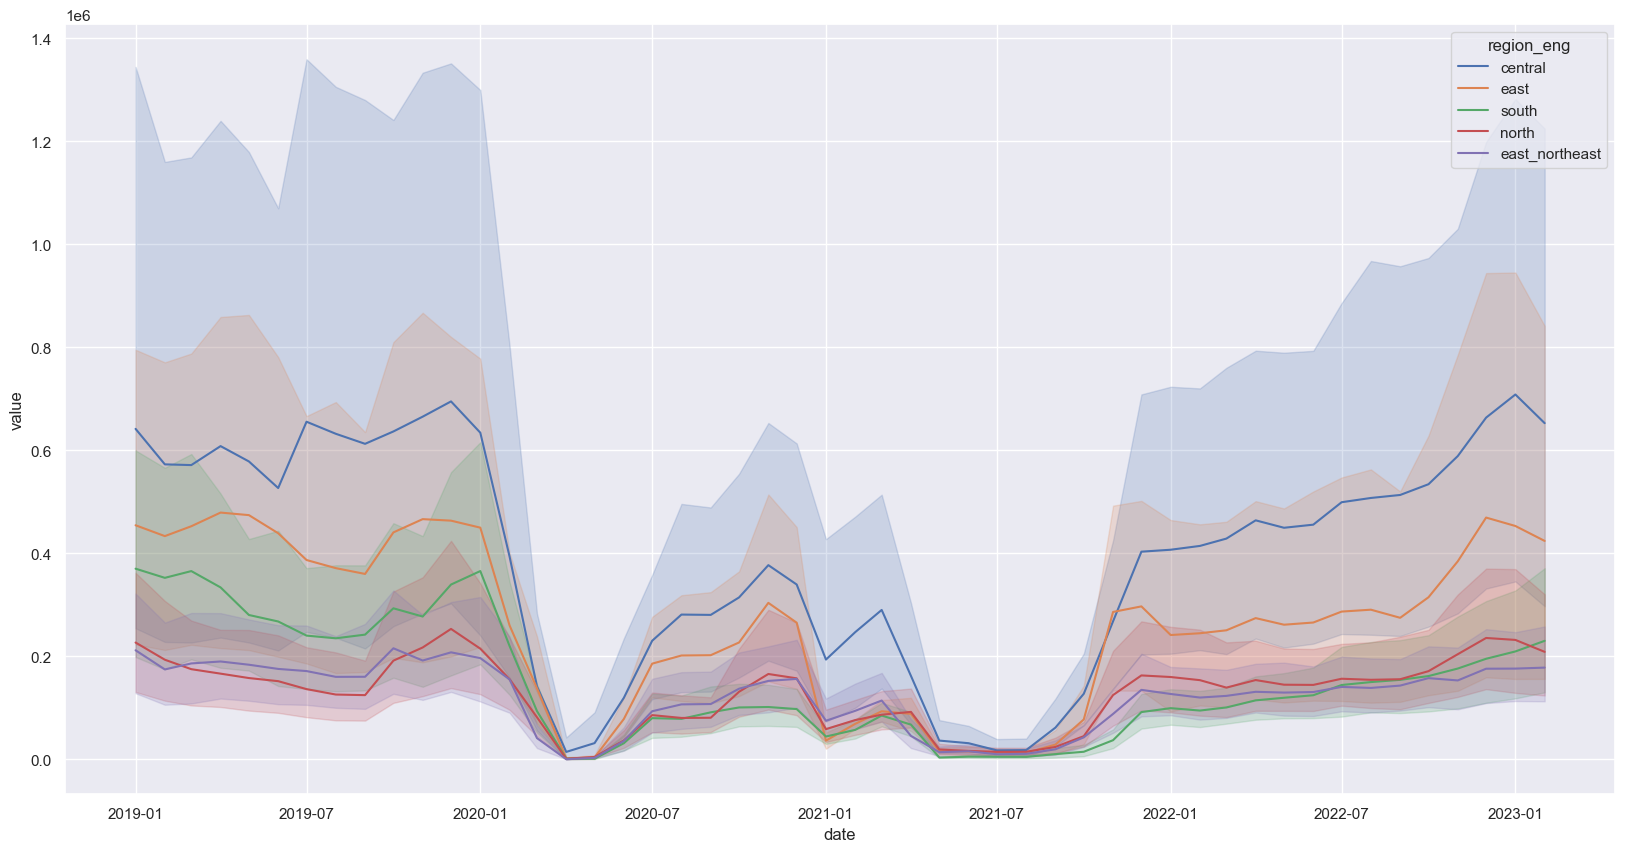

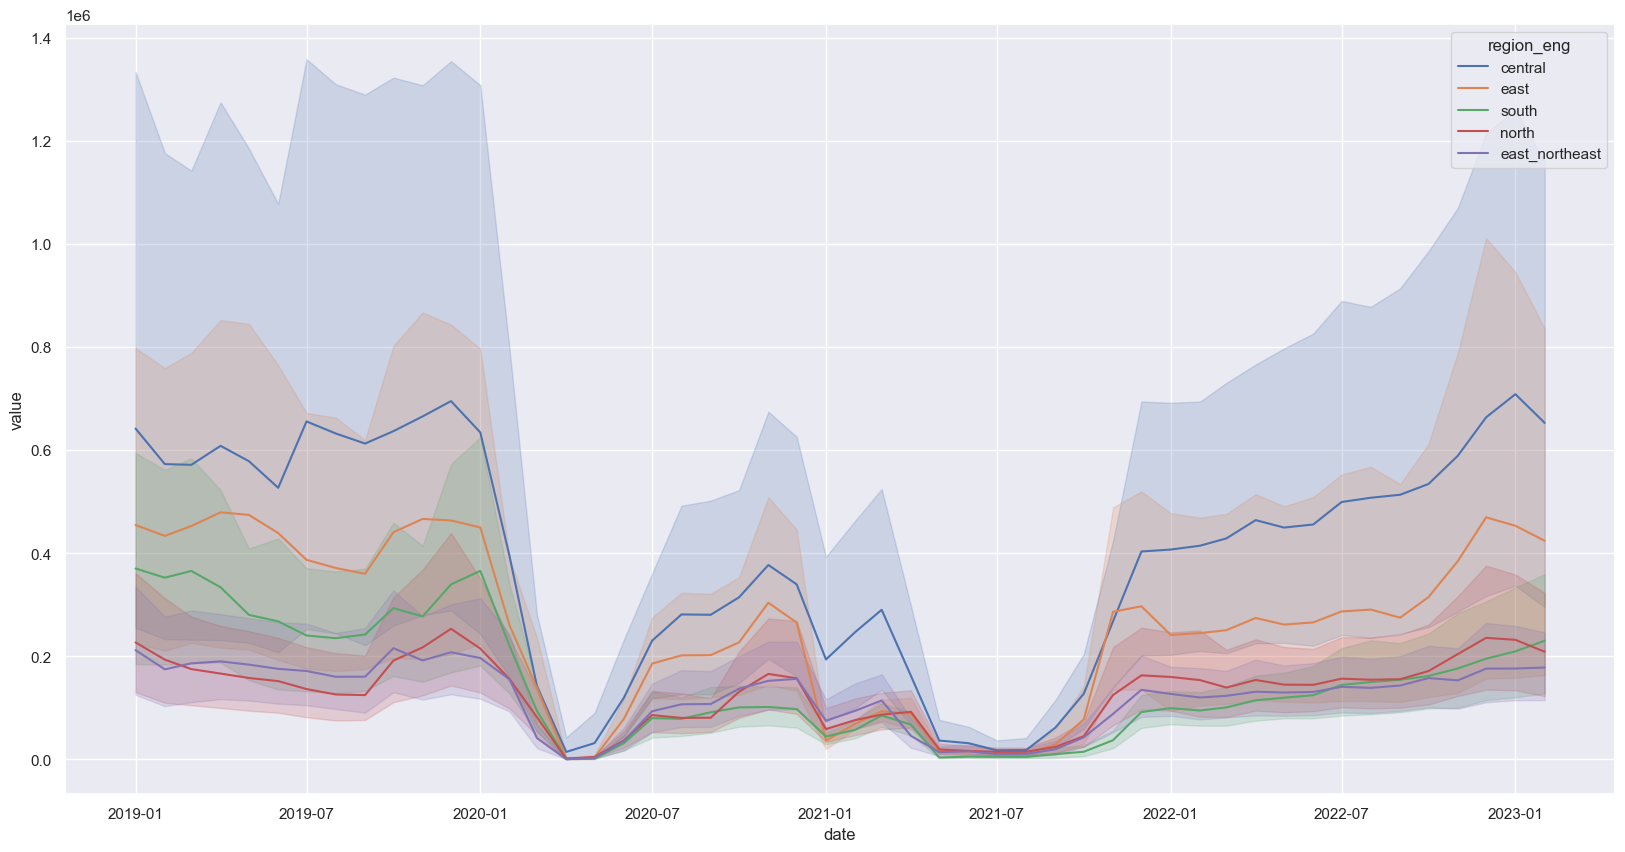

In [330]:
#plot line by eng region on no_tourist by month and year using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=combined_df[combined_df['variable'] == 'no_tourist_all'], x='date', y='value', hue='region_eng')
plt.gcf().set_size_inches(20, 10)

In [319]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30800 entries, 0 to 30799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           30800 non-null  datetime64[ns]
 1   province_thai  30800 non-null  object        
 2   province_eng   30800 non-null  object        
 3   region_thai    30800 non-null  object        
 4   region_eng     30800 non-null  object        
 5   variable       30800 non-null  object        
 6   value          30800 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.9+ MB


In [320]:
combined_df.value_counts("variable")

variable
net_profit_all         3850
net_profit_foreign     3850
net_profit_thai        3850
no_tourist_all         3850
no_tourist_foreign     3850
no_tourist_occupied    3850
no_tourist_thai        3850
occupancy_rate         3850
dtype: int64

In [ ]:
combined_df.

In [ ]:
# replace profit_ string with net_profit_
combined_df['variable'] = combined_df['variable'].replace('profit_tourist_thai', 'net_profit_tourist_thai')
combined_df['variable'] = combined_df['variable'].replace('profit_tourist_foreign', 'net_profit_tourist_foreign')
combined_df['variable'] = combined_df['variable'].replace('profit_all', 'net_profit_all')
combined_df.value_counts("variable")

In [321]:
combined_df.to_csv("thailand_domestic_tourism_2019_2023.csv", index=False)

In [323]:
combined_df.to_parquet("thailand_domestic_tourism_2019_2023.parquet", index=False)

In [324]:
gg = pd.read_parquet("thailand_domestic_tourism_2019_2023.parquet")
gg

,date,province_thai,province_eng,region_thai,region_eng,variable,value
0,2019-01-01,กรุงเทพมหานคร,Bangkok,ภาคกลาง,central,occupancy_rate,93.37
1,2019-01-01,ลพบุรี,Lopburi,ภาคกลาง,central,occupancy_rate,61.32
2,2019-01-01,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,ภาคกลาง,central,occupancy_rate,73.37
3,2019-01-01,สระบุรี,Saraburi,ภาคกลาง,central,occupancy_rate,67.33
4,2019-01-01,ชัยนาท,Chainat,ภาคกลาง,central,occupancy_rate,79.31
...,...,...,...,...,...,...,...
30795,2022-12-01,อุบลราชธานี,Ubon Ratchathani,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,2.48
30796,2022-12-01,สกลนคร,Sakon Nakhon,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,3.52
30797,2022-12-01,ยโสธร,Yasothon,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,0.21
30798,2022-12-01,อำนาจเจริญ,Amnat Charoen,ภาคตะวันออกเฉียงเหนือ,east_northeast,net_profit_foreign,0.66


In [277]:
# select region null row
combined_df[combined_df['region'].isnull()]
# fill nan with ภาคใต้



,date,province,variable,value,Province_thai_x,Province_eng_x,Province_thai_y,Province_eng_y,Province_thai_x,Province_eng_x,Province_thai_y,Province_eng_y,Province_thai_x,Province_eng_x,Province_thai_y,Province_eng_y,region,region_eng
67,2019-01-01,ศรีสะเกษ,occupancy_rate,68.63,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
144,2020-01-01,ศรีสะเกษ,occupancy_rate,65.69,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
221,2021-01-01,ศรีสะเกษ,occupancy_rate,30.18,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
298,2022-01-01,ศรีสะเกษ,occupancy_rate,43.70,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
381,2023-01-01,ศรีสะเกษ,occupancy_rate,42.94,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30482,2022-11-01,ศรีสะเกษ,profit_tourist_foreign,900000.00,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
30559,2019-12-01,ศรีสะเกษ,profit_tourist_foreign,3900000.00,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
30636,2020-12-01,ศรีสะเกษ,profit_tourist_foreign,0.00,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN
30713,2021-12-01,ศรีสะเกษ,profit_tourist_foreign,30000.00,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,ศรีสะเกษ,Sisaket,NaN,NaN


In [276]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30800 entries, 0 to 30799
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             30800 non-null  datetime64[ns]
 1   province         30800 non-null  object        
 2   variable         30800 non-null  object        
 3   value            30800 non-null  float64       
 4   Province_thai_x  30800 non-null  object        
 5   Province_eng_x   30800 non-null  object        
 6   Province_thai_y  30800 non-null  object        
 7   Province_eng_y   30800 non-null  object        
 8   Province_thai_x  30800 non-null  object        
 9   Province_eng_x   30800 non-null  object        
 10  Province_thai_y  30800 non-null  object        
 11  Province_eng_y   30800 non-null  object        
 12  Province_thai_x  30800 non-null  object        
 13  Province_eng_x   30800 non-null  object        
 14  Province_thai_y  30800 non-null  objec

In [268]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30800 entries, 0 to 30799
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           30800 non-null  datetime64[ns]
 1   province       30800 non-null  object        
 2   variable       30800 non-null  object        
 3   value          30800 non-null  float64       
 4   Province_thai  30800 non-null  object        
 5   Province_eng   30800 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.6+ MB


In [264]:
#import dataframe from clipboard
import pandas as pd
df = pd.read_clipboard()
df

,Province_thai,Province_eng
0,กรุงเทพมหานคร,Bangkok
1,ลพบุรี,Lopburi
2,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya
3,สระบุรี,Saraburi
4,ชัยนาท,Chainat
...,...,...
72,อุบลราชธานี,Ubon Ratchathani
73,สกลนคร,Sakon Nakhon
74,ยโสธร,Yasothon
75,อำนาจเจริญ,Amnat Charoen


In [11]:
!apt-get install -y fonts-thai-tlwg

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [246]:
schema = pa.DataFrameSchema(
	columns={
		"province": pa.Column(pa.String, checks= pa.Check.str_matches(r"^[ก-๙]+$"), nullable=False),
		"ratio_tourist_stay": pa.Column(pa.Float, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_stay": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_all": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_thai": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"no_tourist_foreign": pa.Column(pa.Int, checks= pa.Check.ge(0), nullable=False),
		"profit_all": pa.Column(pa.Float, nullable=False),
		"profit_tourist_thai": pa.Column(pa.Float, nullable=False),
		"profit_tourist_foreign": pa.Column(pa.Float, nullable=False),
		"year": pa.Column(pa.Int, checks=pa.Check.between(start_year - 1, end_year), nullable=False),
		"month": pa.Column(pa.String, checks=pa.Check.str_matches(r"^[ก-๙.]+$"), nullable=False),
		"month_no": pa.Column(pa.Int8, checks=pa.Check.between(1, 12), nullable=False)
	},
	checks=pa.Check(lambda df: df["profit_all"] == df["profit_tourist_thai"] + df["profit_tourist_foreign"]) and \
		   pa.Check(lambda df: df["no_tourist_all"] == df["no_tourist_thai"] + df["no_tourist_foreign"])
)

schema(combined_df)

,province,month,year,month_no,ratio_tourist_stay,no_tourist_stay,no_tourist_all,no_tourist_thai,no_tourist_foreign,profit_all,profit_tourist_thai,profit_tourist_foreign
77,กรุงเทพมหานคร,ม.ค.,2019,1,93.37,3334971,5959075,3534061,2425014,8.192649e+10,2.974258e+10,5.218391e+10
78,ลพบุรี,ม.ค.,2019,1,61.32,51858,268664,266301,2363,4.572400e+08,4.518300e+08,5.410000e+06
79,พระนครศรีอยุธยา,ม.ค.,2019,1,73.37,117052,730329,561553,168776,1.438730e+09,1.054250e+09,3.844800e+08
80,สระบุรี,ม.ค.,2019,1,67.33,89850,207236,201400,5836,3.477900e+08,3.361900e+08,1.160000e+07
81,ชัยนาท,ม.ค.,2019,1,79.31,27141,79073,78514,559,1.017900e+08,1.009000e+08,8.900000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
3691,อุบลราชธานี,ธ.ค.,2022,12,50.78,90629,198206,197183,1023,2.839400e+08,2.814600e+08,2.480000e+06
3692,สกลนคร,ธ.ค.,2022,12,53.90,59388,147162,145810,1352,2.137900e+08,2.102700e+08,3.520000e+06
3693,ยโสธร,ธ.ค.,2022,12,36.86,10022,37251,37105,146,3.681000e+07,3.660000e+07,2.100000e+05
3694,อำนาจเจริญ,ธ.ค.,2022,12,37.63,6603,22573,22176,397,2.466000e+07,2.400000e+07,6.600000e+05


In [172]:
start_year

2020

In [145]:
combined_df["profit_tourist_thai"] + combined_df["profit_tourist_foreign"] == combined_df["profit_all"]

77      True
78      True
79      True
80      True
81      True
        ... 
3691    True
3692    True
3693    True
3694    True
3695    True
Length: 3850, dtype: bool

In [124]:
combined_df.query("profit_tourist_foreign == -4250.0")

,province,ratio_stay,no_stay,no_tourist,no_tourist_thai,no_tourist_foreign,profit_all,profit_tourist_thai,profit_tourist_foreign,month,year,month_no
2315,นครปฐม,1.15,1281,4047,4047,0,4015750.0,4020000.0,-4250.0,ก.ค.,2021,7
2392,นครปฐม,0.76,859,2714,2714,0,2625750.0,2630000.0,-4250.0,ส.ค.,2021,8


In [120]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ratio_stay,3850.0,3.892862e+01,2.273898e+01,0.0,2.017500e+01,4.181000e+01,5.619750e+01,9.586000e+01
no_stay,3850.0,1.051611e+05,2.516646e+05,0.0,1.627125e+04,4.457900e+04,9.090200e+04,3.335728e+06
no_tourist,3850.0,2.063285e+05,4.540485e+05,0.0,3.909175e+04,9.212150e+04,2.036460e+05,6.131044e+06
no_tourist_thai,3850.0,1.739624e+05,3.179206e+05,0.0,3.716925e+04,8.878200e+04,1.842558e+05,4.087756e+06
no_tourist_foreign,3850.0,3.236613e+04,1.702651e+05,0.0,4.925000e+01,5.530000e+02,5.189500e+03,2.473725e+06
profit_all,3850.0,1.343876e+09,6.572752e+09,0.0,6.332250e+07,1.954950e+08,5.060000e+08,1.102873e+11
profit_tourist_thai,3850.0,6.636436e+08,2.275008e+09,0.0,5.925000e+07,1.773100e+08,4.600250e+08,4.506024e+10
profit_tourist_foreign,3850.0,6.802322e+08,4.645318e+09,-4250.0,1.100000e+05,1.540000e+06,1.742000e+07,8.502520e+10
year,3850.0,2.020600e+03,1.200156e+00,2019.0,2.020000e+03,2.021000e+03,2.022000e+03,2.023000e+03
month_no,3850.0,6.300000e+00,3.523241e+00,1.0,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01


In [108]:
combined_df['profit_all'] == combined_df['profit_tourist_thai'] + combined_df['profit_tourist_foreign']

77      True
78      True
79      True
80      True
81      True
        ... 
3691    True
3692    True
3693    True
3694    True
3695    True
Length: 3850, dtype: bool

In [99]:
combined_df['year'] = combined_df['year'].astype("int8")
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3850 entries, 77 to 3695
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   province                3850 non-null   object 
 1   ratio_stay              3850 non-null   float64
 2   no_stay                 3850 non-null   int32  
 3   no_tourist              3850 non-null   int32  
 4   no_tourist_thai         3850 non-null   int32  
 5   no_tourist_foreign      3850 non-null   int32  
 6   profit_all              3850 non-null   float64
 7   profit_tourist_thai     3850 non-null   float64
 8   profit_tourist_foreign  3850 non-null   float64
 9   month                   3850 non-null   object 
 10  year                    3850 non-null   int8   
 11  month_no                3850 non-null   int64  
dtypes: float64(4), int32(4), int64(1), int8(1), object(2)
memory usage: 304.5+ KB


In [94]:
combined_df[combined_df['no_tourist_thai'].isnull()]

,province,ratio_stay,no_stay,no_tourist,no_tourist_thai,no_tourist_foreign,profit_all,profit_tourist_thai,profit_tourist_foreign,month,year,month_no
501,สตูล,0.1,84,84.0,NaN,84.0,5.45,0.0,5.45,เม.ย.,2020,4


In [288]:
combined_df.value_counts("variable")

variable
no_tourist_all            3850
no_tourist_foreign        3850
no_tourist_occupied       3850
no_tourist_thai           3850
occupancy_rate            3850
profit_all                3850
profit_tourist_foreign    3850
profit_tourist_thai       3850
dtype: int64

In [ ]:
#pivot combined_df to timeseries
combined_df = combined_df.pivot_table(index=['province', 'year', 'month', 'month_no'], columns='ratio_stay_change', values='ratio_stay_2')

In [84]:
combined_df.info()
# combined_df where profit_tourist_thai is null
combined_df[combined_df['profit_tourist_thai'].isnull()]
# add

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3850 entries, 77 to 3695
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   province                3850 non-null   object 
 1   ratio_stay              3850 non-null   float64
 2   no_stay                 3850 non-null   float64
 3   no_tourist              3850 non-null   float64
 4   no_tourist_thai         3849 non-null   float64
 5   no_tourist_foreign      3850 non-null   float64
 6   profit_all              3850 non-null   float64
 7   profit_tourist_thai     3848 non-null   float64
 8   profit_tourist_foreign  3850 non-null   float64
 9   month                   3850 non-null   object 
 10  year                    3850 non-null   int64  
 11  month_no                3850 non-null   int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 391.0+ KB


,province,ratio_stay,no_stay,no_tourist,no_tourist_thai,no_tourist_foreign,profit_all,profit_tourist_thai,profit_tourist_foreign,month,year,month_no
483,ตราด,0.25,592.0,592.0,0.0,592.0,32.80,NaN,32.80,เม.ย.,2020,4
496,นราธิวาส,0.03,25.0,25.0,0.0,25.0,1.62,NaN,1.62,เม.ย.,2020,4


In [251]:
#melt combined_df to long format
test_df = combined_df.melt(id_vars=['province', 'year', 'month', 'month_no'], value_vars=['ratio_tourist_stay', 'no_tourist_stay', 'no_tourist_all','no_tourist_thai','no_tourist_foreign', 'profit_all', 'profit_tourist_thai', 'profit_tourist_foreign'])
# combine year and month to datetime
test_df['date'] = pd.to_datetime(test_df['year'].astype(str) + '-' + test_df['month_no'].astype(str) + '-01')
test_df = test_df.drop(['year', 'month', 'month_no'], axis=1)
test_df = test_df [['date', 'province', 'variable', 'value']]
test_df

,date,province,variable,value
0,2019-01-01,กรุงเทพมหานคร,ratio_tourist_stay,93.37
1,2019-01-01,ลพบุรี,ratio_tourist_stay,61.32
2,2019-01-01,พระนครศรีอยุธยา,ratio_tourist_stay,73.37
3,2019-01-01,สระบุรี,ratio_tourist_stay,67.33
4,2019-01-01,ชัยนาท,ratio_tourist_stay,79.31
...,...,...,...,...
30795,2022-12-01,อุบลราชธานี,profit_tourist_foreign,2480000.00
30796,2022-12-01,สกลนคร,profit_tourist_foreign,3520000.00
30797,2022-12-01,ยโสธร,profit_tourist_foreign,210000.00
30798,2022-12-01,อำนาจเจริญ,profit_tourist_foreign,660000.00


In [252]:
test_df.describe()

,value
count,3.080000e+04
mean,3.360337e+08
std,2.994697e+09
min,-4.250000e+03
25%,1.740250e+03
50%,9.335250e+04
75%,1.817250e+07
max,1.102873e+11


In [75]:
month_index = {"ม.ค.":1,"ก.พ.":2,"มี.ค.":3,"เม.ย.":4,"พ.ค.":5,"มิ.ย.":6,"ก.ค.":7,"ส.ค.":8,"ก.ย.":9,"ต.ค.":10,"พ.ย.":11,"ธ.ค.":12}
combined_df['month_no'] = combined_df['month'].map(month_index)
combined_df = combined_df.sort_values(["month_no", "year"])
combined_df

,province,ratio,no,no_tour,no_tour_thai,no_tour_foreign,profit,profit_thai,profit_foreign,month,year,month_no
1001,กรุงเทพมหานคร,78.54,3008999.0,6131044.0,3895533.0,2235511.0,104035.66,44719.80,59315.86,7,2019,NaN
1002,ลพบุรี,47.86,38352.0,382896.0,381273.0,1623.0,534.74,531.92,2.82,7,2019,NaN
1003,พระนครศรีอยุธยา,57.19,78614.0,742818.0,553104.0,189714.0,1394.25,949.95,444.30,7,2019,NaN
1004,สระบุรี,49.18,55597.0,421328.0,410699.0,10629.0,511.68,498.34,13.34,7,2019,NaN
1005,ชัยนาท,71.39,24004.0,66583.0,66109.0,474.0,108.19,107.38,0.81,7,2019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3768,ร้อยเอ็ด,63.56,45619.0,106144.0,105296.0,848.0,139.70,137.51,2.19,1,2023,NaN
3769,ศรีสะเกษ,42.94,24872.0,68769.0,68441.0,328.0,80.29,79.53,0.76,1,2023,NaN
3770,สุรินทร์,58.08,75991.0,104405.0,102229.0,2176.0,185.20,180.95,4.25,1,2023,NaN
3771,อำนาจเจริญ,39.46,6934.0,23112.0,22684.0,428.0,25.96,25.17,0.79,1,2023,NaN


In [69]:
combined_df.to_csv("./datasets/combined.csv", index=False)

In [74]:
combined_df.value_counts('month')

month
1     385
2     385
3     308
4     308
5     308
6     308
7     308
8     308
9     308
10    308
11    308
12    308
dtype: int64